In [1]:
%matplotlib inline

import torch
from torch.nn import *

import torchvision
from torchvision.transforms import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchsummary import summary

class YoloLayer(Module):
    def __init__(self, layer_params, pool=True):
        super().__init__()
        layers = []
        for in_channels, out_channels, kernel_size, stride, activation in layer_params:
            layers.append(
                YoloConv(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=kernel_size, stride=stride, activation=activation)
            )
        
        self.in_layers = Sequential(*layers)
        if pool:
            self.pool = MaxPool2d(kernel_size=(2, 2), stride=2)
        else:
            self.pool = Identity()
        
    def forward(self, x):
        x = self.in_layers(x)
        x = self.pool(x)
        return x

class YoloConv(Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), stride=1, activation='relu'):
        super().__init__()
        self.conv = Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels,
                          stride=stride, padding=kernel_size[0] // 2)
        if activation.lower() == 'relu':
            self.activation = LeakyReLU(negative_slope=0.1, inplace=True)
        else:
            self.activation = Identity
            
    def forward(self, x):
        x = self.conv(x)
        self.activation(x)  # inplace
        return x
    
class YoloFinalLayer(Module):
    def __init__(self, activation='relu'):
        super().__init__()
        self.classifier0 = Linear(in_features=50176, out_features=4096)
        if activation.lower() == 'relu':
            self.act = LeakyReLU(negative_slope=0.1, inplace=True)
        else:
            self.act = Identity()
        self.classifier1 = Linear(in_features=4096, out_features=1470)
        
    def forward(self, x):
        x = x.view(-1, 50176)
        x = self.classifier0(x)
        self.act(x)
        x = self.classifier1(x)
        x = x.view(-1, 30, 7, 7)
        return x
    
class YoloFeatureExtractor(Module):
    def __init__(self, activation='relu'):
        super().__init__()
        layers = [
            YoloLayer([
                # in, out, kernel, stride, apoolct
                (3, 64, (7, 7), 2, activation),
            ]),
            YoloLayer([
                (64, 192, (3, 3), 1, activation),
            ]),
            YoloLayer([
                (192, 128, (1, 1), 1, activation),
                (128, 256, (3, 3), 1, activation),
                (256, 256, (1, 1), 1, activation),
                (256, 512, (3, 3), 1, activation),
            ]),
            YoloLayer([
                (512, 256, (1, 1), 1, activation),
                (256, 512, (3, 3), 1, activation),
                (512, 256, (1, 1), 1, activation),
                (256, 512, (3, 3), 1, activation),
                (512, 256, (1, 1), 1, activation),
                (256, 512, (3, 3), 1, activation),
                (512, 256, (1, 1), 1, activation),
                (256, 512, (3, 3), 1, activation),
                (512, 512, (1, 1), 1, activation),
                (512, 1024, (3, 3), 1, activation),
            ]),
            YoloLayer([
                (1024, 512, (1, 1), 1, activation),
                (512, 1024, (3, 3), 1, activation),
                (1024, 512, (1, 1), 1, activation),
                (512, 1024, (3, 3), 1, activation),
            ], pool=False)
        ]
        
        self.layers = Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x
            
class YoloClassifier(Module):
    def __init__(self, activation='relu'):
        super().__init__()
        layers = [
            YoloLayer([
                (1024, 1024, (3, 3), 1, 'relu'),
                (1024, 1024, (3, 3), 2, 'relu'),
            ], pool=False),
            YoloLayer([
                (1024, 1024, (3, 3), 1, 'relu'),
                (1024, 1024, (3, 3), 1, 'relu'),
            ], pool=False),
            YoloFinalLayer('relu')
        ]
        
        self.layers = Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x
        

class YOLOv1(Module):
    def __init__(self):
        super().__init__()
        
        self.features = YoloFeatureExtractor('relu')
        self.classifiers = YoloClassifier('relu')
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifiers(x)
        return x
    
class YOLOv1Pretrainer(Module):
    def __init__(self):
        super().__init__()
        
        self.features = YoloFeatureExtractor('relu')
        self.classifiers = Sequential(
            AvgPool2d(kernel_size=(7, 7)),
            Flatten(),
            Linear(in_features=1024, out_features=1000)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifiers(x)
        return x

model = YOLOv1()
summary(model, input_size=(3, 448, 448), batch_size=2, device='cpu')
# model = YOLOv1Pretrainer()
# summary(model, input_size=(3, 224, 224), batch_size=2, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 224, 224]           9,472
         LeakyReLU-2          [2, 64, 224, 224]               0
          YoloConv-3          [2, 64, 224, 224]               0
         MaxPool2d-4          [2, 64, 112, 112]               0
         YoloLayer-5          [2, 64, 112, 112]               0
            Conv2d-6         [2, 192, 112, 112]         110,784
         LeakyReLU-7         [2, 192, 112, 112]               0
          YoloConv-8         [2, 192, 112, 112]               0
         MaxPool2d-9           [2, 192, 56, 56]               0
        YoloLayer-10           [2, 192, 56, 56]               0
           Conv2d-11           [2, 128, 56, 56]          24,704
        LeakyReLU-12           [2, 128, 56, 56]               0
         YoloConv-13           [2, 128, 56, 56]               0
           Conv2d-14           [2, 256,

# Prepare dataset
- We will prepare ILSVRC2012 dataset!

In [3]:
class LabelReader(object):
    def __init__(self, label_file_path):
        self.label_file_path = label_file_path
        if 'pretrained' in label_file_path:
            print("INFO: Using Pretrained label list! (not custom one)")

    def load_label(self):
        label_map = {}
        # Read label file into label map
        if os.path.isfile(self.label_file_path):
            with open(self.label_file_path, 'r') as f:
                label_name_body = f.read().strip()
                label_name_lines = label_name_body.split("\n")
                for label_entry in tqdm(label_name_lines, desc='레이블 파일 읽기 작업'):
                    synset_name, label_name = label_entry.strip().split("|")
                    label_map[synset_name] = label_name

            print(f"레이블 파일 읽기 완료: 총 {len(list(label_map.keys()))}개 레이블 검색")
            return label_map
        else:
            return None

class ImageNet(torch.utils.data.Dataset):
    def __init__(self, labels, root_dir, transform=None):
        super(ImageNet, self).__init__()

        self.labels = labels
        self.transform = transform

        self.img_path_list = []
        self.img_class_list = []
        self.load_list(root_dir)

    def load_list(self, root_dir):
        label_index = 0
        for label in tqdm(self.labels.keys(), desc='이미지 파일 리스트 읽기 작업'):
            item_dir = os.path.join(root_dir, label)
            file_list = glob.glob(item_dir + os.sep + "*.JPEG")
            self.img_path_list += file_list
            self.img_class_list += [label_index] * len(file_list)
            label_index += 1

        if len(self.img_path_list) != len(self.img_class_list):
            raise RuntimeError(f"이미지 데이터 {len(self.img_path_list)}개와 클래스 데이터 {len(self.img_class_list)}개가 서로 다릅니다!")

        print(f"총 {len(self.img_path_list)}개 이미지 리스트 데이터 및 실효 레이블 {len(list(set(self.img_class_list)))}개 로드 성공")

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # PIL-version
        image = Image.open(self.img_path_list[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = torch.Tensor([self.img_class_list[idx]]).type(torch.int64).squeeze(dim=0)
        return image, label

In [4]:
import os

DATASET_BASEDIR = '/media/jungin500/windows-10/Dataset/ILSVRC/Data/CLS-LOC/train/'
if not os.path.isdir(DATASET_BASEDIR):
    print("ERROR: Dataset path not exists!")

# Prepare dataset (VOC2012 for Object Detection task)
- VOC2012의 XML parsing과 이를 이용한 GT generation을 진행한다.
- YOLOv1의 Output shape는 `30*7*7`이다.

- 구성: `30 = { {x, y, w, h, c}, {x, y, w, h, c}, {classes ... } }` (총 30개 entry)

In [5]:
from glob import glob
from tqdm.auto import tqdm
from xml.etree import ElementTree

import torch
import os
import math

class VOCYOLOAnnotator(object):
    def __init__(self, annotation_root, image_root, model_cells=7, extension='jpg'):
        super().__init__()
        self.annotation_root = annotation_root
        self.image_root = image_root
        self.model_cells = model_cells
        
        self.annotation_files = glob(os.path.join(annotation_root, '*.xml'))
        self.labels = self.find_object_names()
        
    def find_object_names(self):
        object_map = {}
        for xml_filename in tqdm(self.annotation_files, desc='Annotation 내 Object Names 검색'):
            with open(xml_filename, 'r') as f:
                root = ElementTree.fromstring(f.read())
                for item in root.findall('object'):
                    object_name = item.find('name').text.strip()
                    object_map[object_name] = 1
        return list(sorted(object_map.keys()))
    
    def parse_annotation(self):
        annotations = []
        for xml_filename in tqdm(self.annotation_files,  desc='Annotation 검색'):
            with open(xml_filename, 'r') as f:
                root = ElementTree.fromstring(f.read())
                size = root.find('size')
                
                filename = root.find('filename').text.strip()
                filepath = os.path.join(self.image_root, filename)
                image_width, image_height = int(size.find('width').text), int(size.find('height').text)
                objects = []
                for item in root.findall('object'):
                    object_name = item.find('name').text.strip()
                    object_id = self.labels.index(object_name)
                    
                    object_bndbox = item.find('bndbox')
                    (xmin, ymin, xmax, ymax) = [
                        float(object_bndbox.find(key).text) for key in ['xmin', 'ymin', 'xmax', 'ymax']
                    ]
                    
                    assert(object_id != -1)
                    
                    xmin_norm, ymin_norm = xmin / image_width, ymin / image_height
                    width, height = xmax - xmin, ymax - ymin
                    width_norm, height_norm = width / image_width, height / image_height
                    xcenter_norm, ycenter_norm = xmin_norm + width_norm / 2, ymin_norm + height_norm / 2
                    
                    # dynamic range tricks
                    # changes dynamic range from 0.0 to 7.0 and do floor()
                    # -> results 0, 1, 2, 3, 4, 5, 6!
                    cell_idx_x = math.floor(xcenter_norm * self.model_cells)
                    cell_idx_y = math.floor(ycenter_norm * self.model_cells)
                    
                    cell_pos_x_norm = (xcenter_norm - (cell_idx_x / self.model_cells))
                    cell_pos_y_norm = (ycenter_norm - (cell_idx_y / self.model_cells))
                    
                    objects.append([object_id, cell_idx_x, cell_idx_y, cell_pos_x_norm, cell_pos_y_norm, width_norm, height_norm])
                
                annotations.append((filepath, objects))
            
        return annotations

In [6]:
annotator = VOCYOLOAnnotator(
    annotation_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/Annotations',
    image_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: /media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages/2007_000256.jpg
Annotation[1]: [[0, 3, 3, 0.07042857142857145, 0.0495626822157435, 0.966, 0.3965014577259475]]


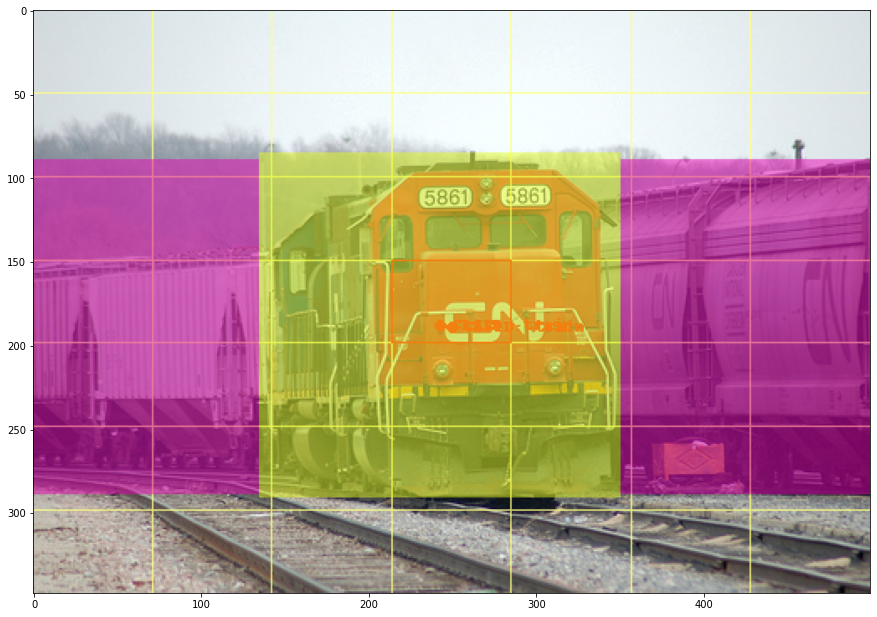

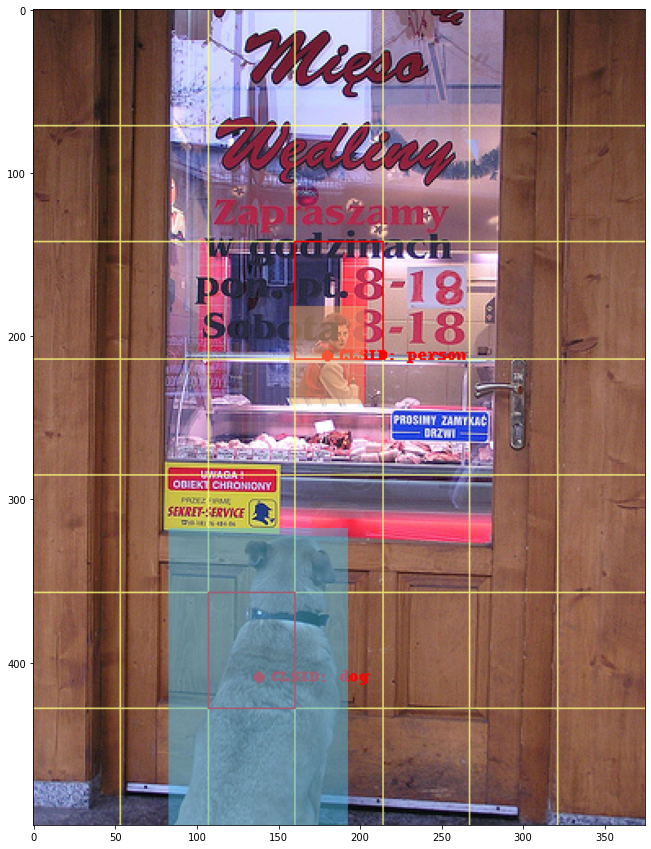

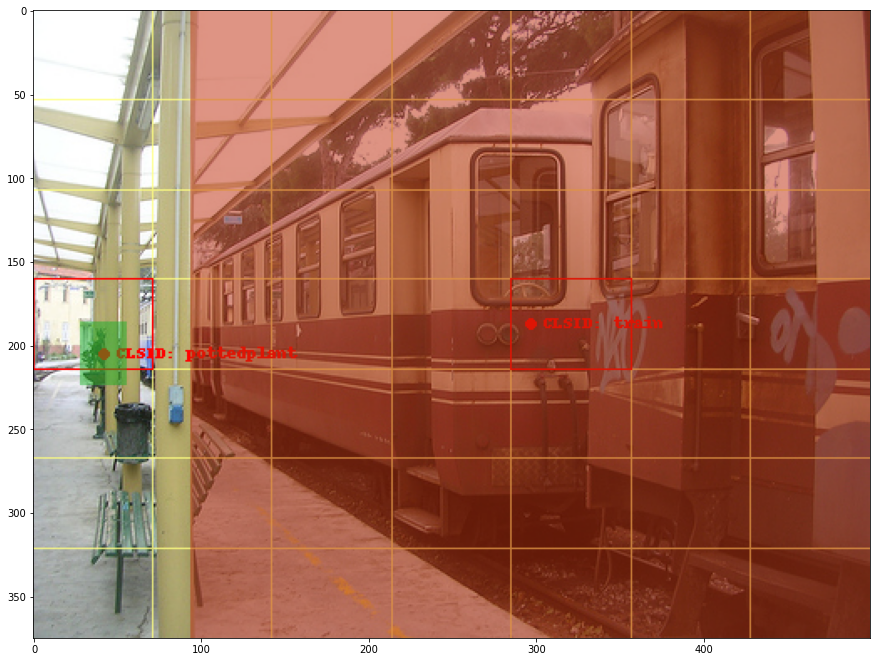

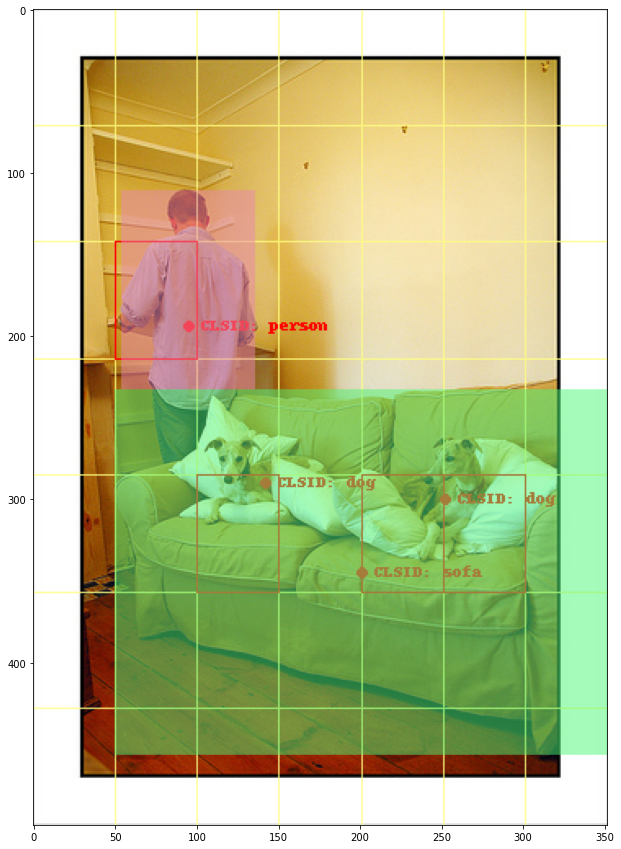

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange

def draw_cell_boundaries(image, cells=7):
    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(image)
    overlay_draw = ImageDraw.Draw(overlay)
    image_width, image_height = image.size
    
    fill_color = (255, 255, 128, 200)
    
    unit = image_width / cells
    for idx in range(1, cells):
        vertical_line_x = unit * idx
        overlay_draw.line([(vertical_line_x, 0), (vertical_line_x, image_height)], fill=fill_color)

    unit = image_height / cells
    for idx in range(1, cells):
        horizontal_line_y = unit * idx
        overlay_draw.line([(0, horizontal_line_y), (image_width, horizontal_line_y)], fill=fill_color)
        
    return Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
def draw_center_cell_object(image, annotator, annotation, cells=7):
    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(image)
    overlay_draw = ImageDraw.Draw(overlay)
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    for item in annotation:
        (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) = item

        horizontal_unit = image_width / cells
        vertical_unit = image_height / cells

        class_name = annotator.labels[class_id]

        # draw center cell as red color
        cxmin = horizontal_unit * cell_idx_x
        cxmax = horizontal_unit * (cell_idx_x + 1)
        cymin = vertical_unit * cell_idx_y
        cymax = vertical_unit * (cell_idx_y + 1)
        
        draw.line([(cxmin, cymin), (cxmax, cymin)], fill=fill_color)
        draw.line([(cxmax, cymin), (cxmax, cymax)], fill=fill_color)
        draw.line([(cxmax, cymax), (cxmin, cymax)], fill=fill_color)
        draw.line([(cxmin, cymax), (cxmin, cymin)], fill=fill_color)
        
        cell_obj_center_x = int(cxmin + (cell_pos_x * image_width))
        cell_obj_center_y = int(cymin + (cell_pos_y * image_height))
        
        oxmin, oxmax = int(cell_obj_center_x + (width * image_width / 2)), int(cell_obj_center_x - (width * image_width / 2))
        oymin, oymax = int(cell_obj_center_y + (height * image_height / 2)), int(cell_obj_center_y - (height * image_height / 2))
        
        draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
        draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)
        
        random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
        overlay_color = (random_color_r, random_color_g, random_color_b, 128)
        overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color
        
    return Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
    
samples = 4

for _ in range(samples):
    random_sample = randrange(len(annotations))
    filepath, annotation = annotations[random_sample]

    image = Image.open(filepath)
    image = draw_cell_boundaries(image, cells=7)
    image = draw_center_cell_object(image, annotator, annotation, cells=7)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(np.asarray(image))

In [9]:
class VOCYolo(torch.utils.data.Dataset):
    def __init__(self, labels, annotations, boxes=2, grid_size=7, transform=None):
        super(VOCYolo, self).__init__()
        self.labels = labels
        self.annotations = annotations
        self.transform = transform
        self.boxes = boxes
        self.grid_size = grid_size
        self.classes = 20  # fixed as it's VOC dataset!
        self.one_hot = torch.eye(self.classes)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        filepath, annotation = self.annotations[idx]
        image = Image.open(filepath).convert('RGB')  # case if image is grayscale
        label = torch.zeros((5 + self.classes, self.grid_size, self.grid_size), dtype=torch.float)
        
        # fill label
        for (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) in annotation:
            if label[4, cell_idx_y, cell_idx_x] != 1.0:
                label[:5, cell_idx_y, cell_idx_x] = torch.from_numpy(np.array([cell_pos_x, cell_pos_y, width, height, 1.0], dtype=np.double))
                label[5:, cell_idx_y, cell_idx_x] = self.one_hot[class_id]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

class ImageNet(torch.utils.data.Dataset):
    def __init__(self, labels, root_dir, transform=None):
        super(ImageNet, self).__init__()

        self.labels = labels
        self.transform = transform

        self.img_path_list = []
        self.img_class_list = []
        self.load_list(root_dir)

    def load_list(self, root_dir):
        label_index = 0
        for label in tqdm(self.labels.keys(), desc='이미지 파일 리스트 읽기 작업'):
            item_dir = os.path.join(root_dir, label)
            file_list = glob.glob(item_dir + os.sep + "*.JPEG")
            self.img_path_list += file_list
            self.img_class_list += [label_index] * len(file_list)
            label_index += 1

        if len(self.img_path_list) != len(self.img_class_list):
            raise RuntimeError(f"이미지 데이터 {len(self.img_path_list)}개와 클래스 데이터 {len(self.img_class_list)}개가 서로 다릅니다!")

        print(f"총 {len(self.img_path_list)}개 이미지 리스트 데이터 및 실효 레이블 {len(list(set(self.img_class_list)))}개 로드 성공")

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # PIL-version
        image = Image.open(self.img_path_list[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = torch.Tensor([self.img_class_list[idx]]).type(torch.int64).squeeze(dim=0)
        return image, label
    

# Prepare for YoloLoss
- We will implement YoloLoss described in paper!
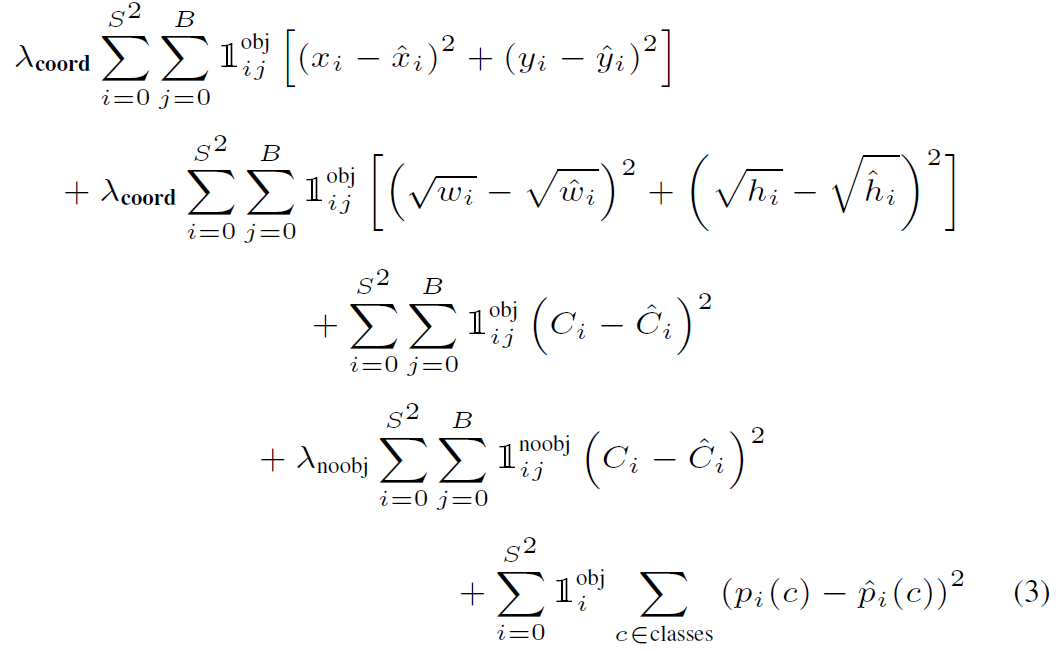

## Implementation details of loss term
- `lambda_coord = 5`, `lambda_noobj = 0.5`
- Term #1: **GT에 Object가 존재하는 Cell과 box index에 한해서** 모든 Cell `i`과 모든 bounding boxes 에서 GT Coordinate와 Detector의 output coordinate 간의 차이 (Squared Sum of Difference Loss)를 합한다.
- Term #2: **GT에 Object가 존재하는 Cell과 box index에 한해서** 모든 Cell `i`과 모든 bounding boxes 에서 GT width/height와 Detector의 output width/height 간의 차이를 합한다. 이 때 scale을 위해서 sqrt()를 진행한다.
- Term #3: **GT에 Object가 존재하는 Cell과 box index에 한해서** Confidence Loss의 차이 (SSD Loss)를 합한다.
- Term #4: **GT에 Object가 __존재하지 않는 Cell과 box index__에 한해서** 동일하게 Confidence의 차이를 합한다. 이 때, GT confidence는 0이다. 이에 유의한다.
- Term #5: **GT에 Object가 존재하는 Cell에 한해서** Class probability의 차이를 합친다. (SSD Loss)

## Implementation details of nonlinearities
- Term 1, 2까지는 xywh를 다루고 있다.
    - xywh는 모두 (0.0, 1.0)까지의 dynamic range를 가지고 있다.
    - xy는 grid cell 내부의 위치를 기준으로, grid의 시작점을 0으로, grid의 끝점을 1으로 잡는다.
    - wh는 resized input image를 기준으로, 이미지의 크기와 동일한 크기를 1으로, 작은 bbox는 0에 가깝게 잡는다.
    - nonlinearity는 4가지 모두 sigmoid를 이용한다.
- Term 3, 4의 경우 Confidence를 다루고 있다.
    - Sigmoid로 0부터 1까지로 제한할 필요가 있다.
- Term 5의 경우 class probability (VOC의 경우 20개)를 나타낸다.
    - **(반드시) Per-cell** Softmax와 Cross Entropy Loss로 해결한다.

In [101]:
class YoloLoss(Module):
    def __init__(self, lambda_coord, lambda_noobj):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.eps = 1e-15 # for sqrt(0), we will do sqrt(0 + eps)
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        assert((input.shape[1] - 20) % 5 == 0)
        bboxes = (input.shape[1] - 20) // 5
        
        # applies outer-model sigmoid function
        input = torch.sigmoid(input)
        
        # target: [cell_pos_x, cell_pos_y, width, height, 1.0] * 7 * 7
        object_gt_exist_mask = target[:, 4:5, :, :] == 1
        responsible_bbox_index_mask = YoloLoss.get_responsible_bbox_predictor_mask(input, target, bboxes)
        
        loss = 0
        for bbox_id in range(bboxes):
            current_box = input[:, 5 * bbox_id:5 * (bbox_id + 1), :, :]
            
            # we should use with object_gt_exist_mask
            # because non-object-existant mask will have zero index
            current_box_responsible_mask = responsible_bbox_index_mask == bbox_id
            
            #! TODO: iterate over xy_loss and find out that object_gt_exist_mask works well
            xy_loss = torch.square(current_box[:, :2, :, :] - target[:, :2, :, :]) * object_gt_exist_mask * current_box_responsible_mask
            loss += self.lambda_coord * torch.sum(xy_loss)
            # print("xy_loss ", torch.sum(xy_loss))
            
            wh_loss = torch.square(torch.sqrt(current_box[:, 2:4, :, :] + self.eps) - torch.sqrt(target[:, 2:4, :, :] + self.eps)) * object_gt_exist_mask * current_box_responsible_mask
            loss += self.lambda_coord * torch.sum(wh_loss)
            # print("wh_loss: ", torch.sum(wh_loss))
            # print("wh_loss current_box sqrt", torch.sum(torch.sqrt(current_box[:, 2:4, :, :] + self.eps)))
            # print("wh_loss target sqrt", torch.sum(torch.sqrt(target[:, 2:4, :, :] + self.eps)))
            
            conf_obj_loss = torch.square(current_box[: 4:5, :, :] - target[:, 4:5, :, :]) * object_gt_exist_mask * current_box_responsible_mask
            conf_noobj_loss = torch.square(current_box[: 4:5, :, :] - target[:, 4:5, :, :]) * ~(object_gt_exist_mask * current_box_responsible_mask)
            loss += torch.sum(conf_obj_loss)
            loss += self.lambda_noobj * torch.sum(conf_noobj_loss)
            # print("conf_obj_loss: ", torch.sum(conf_obj_loss))
            # print("conf_noobj_loss: ", torch.sum(conf_noobj_loss))
            
        class_loss = torch.square(input[:, (5 * bboxes):, :, :] - target[:, 5:, :, :])
        loss += torch.sum(class_loss)
        # print("class_loss: ", torch.sum(class_loss))
            
        return loss
    
    @staticmethod
    def get_responsible_bbox_predictor_mask(input: Tensor, target: Tensor, bboxes: int) -> Tensor:
        ious = []
        for bbox_id in range(bboxes):
            current_box_xywh = input[:, 5 * bbox_id:5 * (bbox_id + 1) - 1, :, :]
            label_xywh = target[:, :4, :, :]
            
            # iou -> (B * 7 * 7)
            iou = YoloLoss.get_iou_xywh(current_box_xywh, label_xywh)
            ious.append(iou)
        
        # stacked_iou -> (B * 2 * 7 * 7)
        stacked_iou = torch.stack(ious, dim=1)
        # print(stacked_iou.shape, torch.argmax(stacked_iou, dim=1, keepdim=True).shape)
        
        return torch.argmax(stacked_iou, dim=1, keepdim=True)
    
    @staticmethod
    def get_iou_xywh(input_xywh: Tensor, label_xywh: Tensor) -> Tensor:
        # index_map -> [1, 2, 7, 7]
        index_map_x = torch.arange(0, 7).repeat(7)
        index_map_y = torch.repeat_interleave(torch.arange(0, 7), 7)
        index_map = torch.unsqueeze(torch.stack([index_map_y, index_map_x], dim=0).view(2, 7, 7), 0)
        
        input_xy_global = (input_xywh[:, :2, :, :] + index_map) / 7
        input_width_half, input_height_half = (input_xywh[:, 2, :, :] / 2), (input_xywh[:, 3, :, :] / 2)
        input_xmin = input_xy_global[:, 0, :, :] - input_width_half  # x_center - width / 2
        input_xmax = input_xy_global[:, 0, :, :] + input_width_half
        input_ymin = input_xy_global[:, 1, :, :] - input_height_half
        input_ymax = input_xy_global[:, 1, :, :] + input_height_half
        
        label_xy_global = (label_xywh[:, :2, :, :] + index_map) / 7
        label_width_half, label_height_half = (label_xywh[:, 2, :, :] / 2), (label_xywh[:, 3, :, :] / 2)
        label_xmin = label_xy_global[:, 0, :, :] - label_width_half  # x_center - width / 2
        label_xmax = label_xy_global[:, 0, :, :] + label_width_half
        label_ymin = label_xy_global[:, 1, :, :] - label_height_half
        label_ymax = label_xy_global[:, 1, :, :] + label_height_half

        input_volume = input_xywh[:, 2, :, :] * input_xywh[:, 3, :, :]
        label_volume = label_xywh[:, 2, :, :] * label_xywh[:, 3, :, :]
        intersect_width = torch.minimum(input_xmax, label_xmax) - torch.maximum(input_xmin, label_xmin)
        intersect_height = torch.minimum(input_ymax, label_ymax) - torch.maximum(input_ymin, label_ymin)
        intersect_volume = intersect_width * intersect_height
        union_volume = input_volume + label_volume - intersect_volume
        
        return intersect_volume / union_volume

In [93]:
print(torch.arange(0, 7).repeat(7))
print(torch.repeat_interleave(torch.arange(0, 7), 7))
index_map_x = torch.arange(0, 7).repeat(7)
index_map_y = torch.repeat_interleave(torch.arange(0, 7), 7)
index_map = torch.unsqueeze(torch.stack([index_map_y, index_map_x], dim=0).view(2, 7, 7), 0)
print(index_map)
print(index_map.shape)

print("Should say 6, 5 (orderly y, x) -> ", index_map[0, 0, 6, 5], index_map[0, 1, 6, 5])

tensor([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
        3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
        6])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6])
tensor([[[[0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1],
          [2, 2, 2, 2, 2, 2, 2],
          [3, 3, 3, 3, 3, 3, 3],
          [4, 4, 4, 4, 4, 4, 4],
          [5, 5, 5, 5, 5, 5, 5],
          [6, 6, 6, 6, 6, 6, 6]],

         [[0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6],
          [0, 1, 2, 3, 4, 5, 6]]]])
torch.Size([1, 2, 7, 7])
Should say 6, 5 (orderly y, x) ->  tensor(6) tensor(5)


In [100]:
import torchvision.transforms
from torchvision.transforms import *

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4547857, 0.4349471, 0.40525291],
            std=[0.12003352, 0.12323549, 0.1392444]
        )
    ])
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=2, num_workers=0, pin_memory=True)

model = YOLOv1().float()

criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5)
# scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters())
    
for i, (image, label) in enumerate(train_dataloader):
    if i > 1:
        break
        
#     with torch.cuda.amp.autocast():
#         image = image.cuda(non_blocking=True)
#         label = label.cuda(non_blocking=True)
        
    output = model(image)
    loss = criterion(output, label)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()
#     optimizer.zero_grad(set_to_none=True)
    
    print("Batch %d/%d: Loss %.6f" % (i, len(train_dataloader), loss))

torch.Size([2, 2, 7, 7]) torch.Size([2, 1, 7, 7])
xy_loss  tensor(0.7800, grad_fn=<SumBackward0>)
wh_loss:  tensor(0.1940, grad_fn=<SumBackward0>)
wh_loss current_box sqrt tensor(138.5918, grad_fn=<SumBackward0>)
wh_loss target sqrt tensor(4.1770)
conf_obj_loss:  tensor(2.5017, grad_fn=<SumBackward0>)
conf_noobj_loss:  tensor(120.0250, grad_fn=<SumBackward0>)
xy_loss  tensor(0.3396, grad_fn=<SumBackward0>)
wh_loss:  tensor(0.0797, grad_fn=<SumBackward0>)
wh_loss current_box sqrt tensor(138.5712, grad_fn=<SumBackward0>)
wh_loss target sqrt tensor(4.1770)
conf_obj_loss:  tensor(1.2508, grad_fn=<SumBackward0>)
conf_noobj_loss:  tensor(121.1886, grad_fn=<SumBackward0>)
class_loss:  tensor(489.8318, grad_fn=<SumBackward0>)
Batch 0/2548: Loss 621.157288
torch.Size([2, 2, 7, 7]) torch.Size([2, 1, 7, 7])
xy_loss  tensor(1.0166, grad_fn=<SumBackward0>)
wh_loss:  tensor(0.4590, grad_fn=<SumBackward0>)
wh_loss current_box sqrt tensor(138.5918, grad_fn=<SumBackward0>)
wh_loss target sqrt tensor(6.

In [8]:
import cv2
import numpy as np
from tqdm.auto import tqdm

values = np.zeros((3, len(annotations)))

for image_index, (image_path, annotation) in tqdm(enumerate(annotations), total=len(annotations), desc='Calculate average of image'):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_by_channels = cv2.split(image)

    values[0, image_index] = np.mean(image_by_channels[0])
    values[1, image_index] = np.mean(image_by_channels[1])
    values[2, image_index] = np.mean(image_by_channels[2])

mean = np.mean(values, axis=1) / 255
std = np.std(values, axis=1) / 255

print("Mean: ", mean)
print("StdDev: ", std)

Calculate average of image:   0%|          | 0/5096 [00:00<?, ?it/s]

Mean:  [0.4547857  0.4349471  0.40525291]
StdDev:  [0.12003352 0.12323549 0.1392444 ]
